In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.simplefilter(action="ignore", category=FutureWarning)
import sys

sys.path.append("../")

import optuna

from straindesignxai.main import DataLoader

RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

/home/costasmexis/miniconda3/envs/synthetic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[14:30:32] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the follo

Dataset size: (30, 10)
New data shape: (27, 10)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

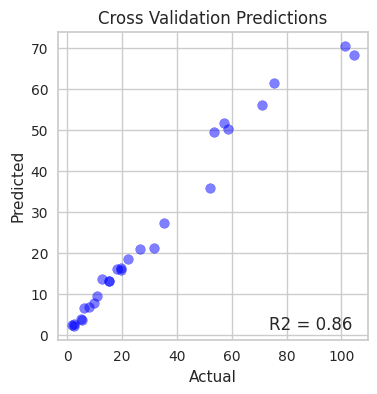

In [2]:
dl = DataLoader(PATH, INPUT_VARS, RESPONSE_VARS)
dl.get_bounds()

cycle = 'DBTL_A'
# cycle = 'all'

if cycle == 'DBTL_A':
    # Keep only DBTL_A indexes
    dl.df = dl.df[dl.df.index.isin(DBTL_A)]
    dl.X = dl.df[INPUT_VARS]
    dl.y = dl.df[RESPONSE_VARS]
    print(f"New data shape: {dl.df.shape}")

    try:
        dl.load_model("../models/xgb_limonene.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene.pkl")

elif cycle == 'all':
    try:
        dl.load_model("../models/xgb_limonene_all.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene_all.pkl")    
    
dl.plot_R2()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

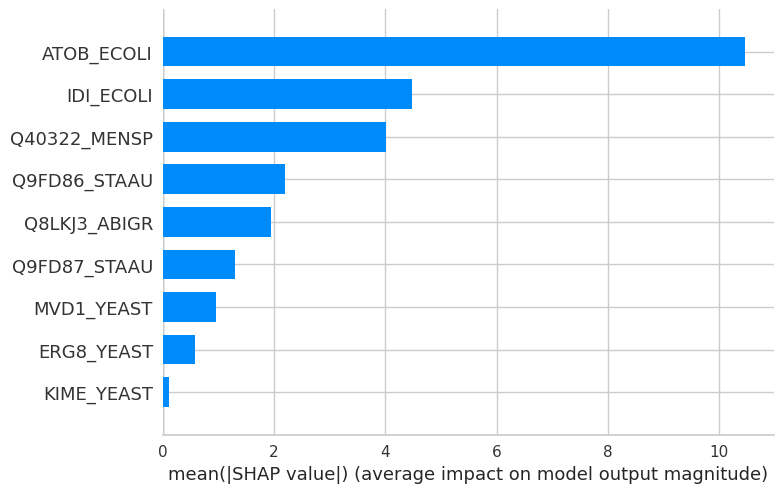

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

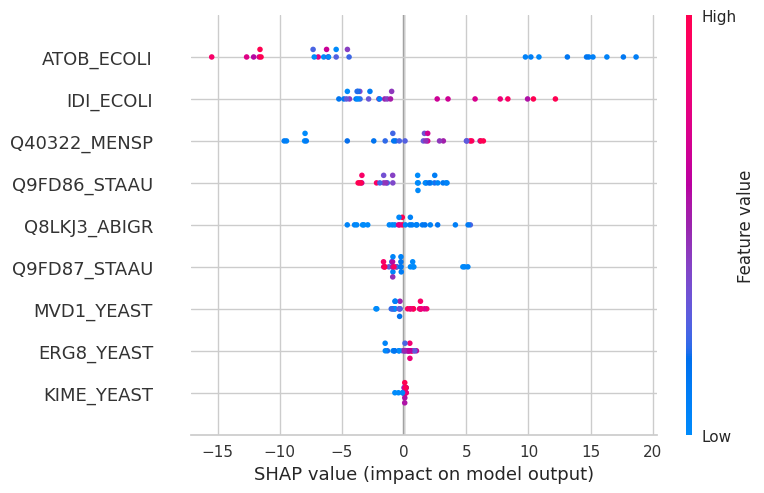

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

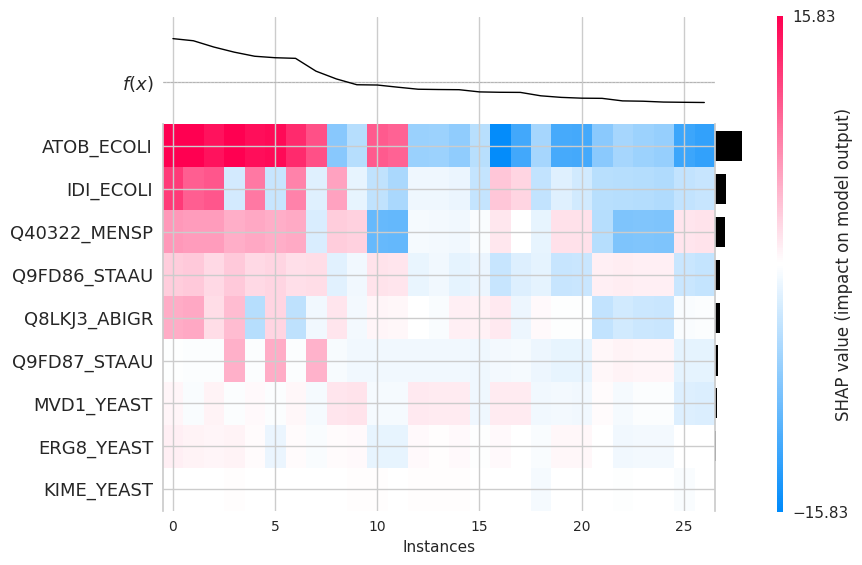

In [3]:
dl.get_shap_values()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

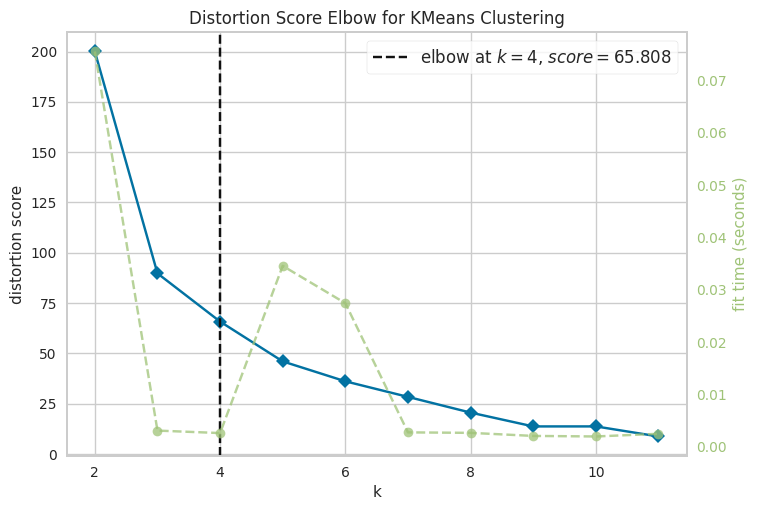

Optimal number of clusters: 4


In [4]:
dl.supervised_clustering()

In [5]:
dl.study_clusters()

Number of elements in each cluster: 
cluster
0    14
3     5
1     5
2     3
Name: count, dtype: int64


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.664971,0.666893,1.338579,0.254064,1.230621,3.749186,1.084307,1.563443,2.050229,10.931601
1,0.206480,0.707940,2.525160,0.330960,1.730520,8.523380,0.420080,0.540460,0.564080,78.341800
2,0.912200,0.707467,2.075733,0.308667,1.695533,4.429967,0.394533,2.661100,3.197000,21.957007
3,0.119180,0.311060,1.082380,0.151280,0.762520,3.047580,0.356020,0.160800,0.248800,46.023752


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.664971,0.666893,1.338579,0.254064,1.230621,3.749186,1.084307,1.563443,2.050229,10.931601
1,0.206480,0.707940,2.525160,0.330960,1.730520,8.523380,0.420080,0.540460,0.564080,78.341800
2,0.912200,0.707467,2.075733,0.308667,1.695533,4.429967,0.394533,2.661100,3.197000,21.957007
3,0.119180,0.311060,1.082380,0.151280,0.762520,3.047580,0.356020,0.160800,0.248800,46.023752


### Study top producting cluster

In [6]:
dl.df["pred"] = dl.model.predict(dl.df.drop(["Limonene", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    dl.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)

dl.df[dl.df["cluster"] == top_cluster]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene,cluster,pred
2X.Lm,0.1720,0.6213,2.5226,0.3043,1.6258,8.4749,0.2245,0.4305,0.4944,56.97134,1,51.756355
2X.Lh,0.2335,0.7463,2.3338,0.3196,1.7450,9.1728,0.2534,0.6998,0.6607,53.60310,1,49.505325
2X.Mm,0.2231,0.7901,2.7354,0.3744,1.9592,9.2338,0.4335,0.5118,0.5409,101.20540,1,70.643181
2X.Mh,0.2384,0.9413,3.1813,0.4010,2.1936,11.2037,0.2968,0.7816,0.7488,75.39261,1,61.636490
B.Ml,0.1654,0.4407,1.8527,0.2555,1.1290,4.5317,0.8922,0.2786,0.3756,104.53655,1,68.364120


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

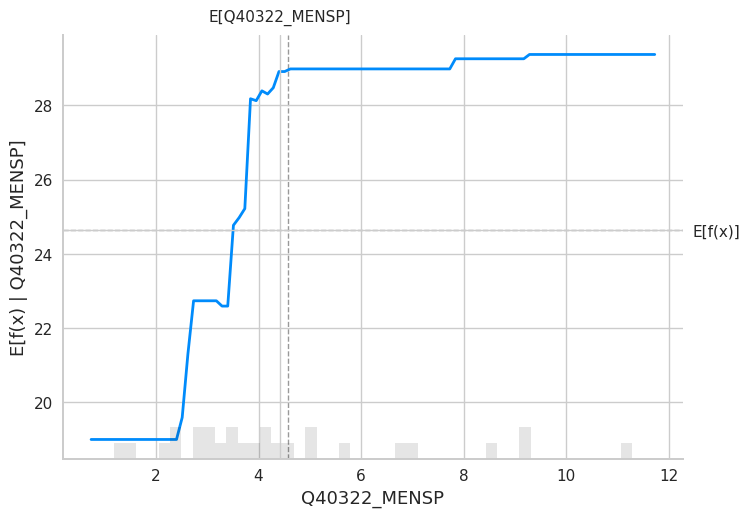

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

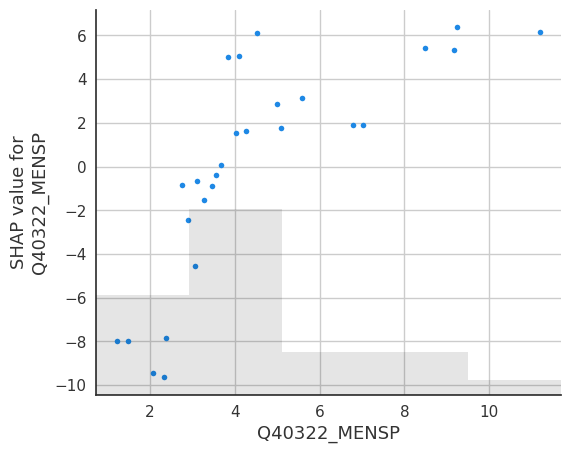

In [7]:
dl.pdplot("Q40322_MENSP")
dl.shap_scatter("Q40322_MENSP")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

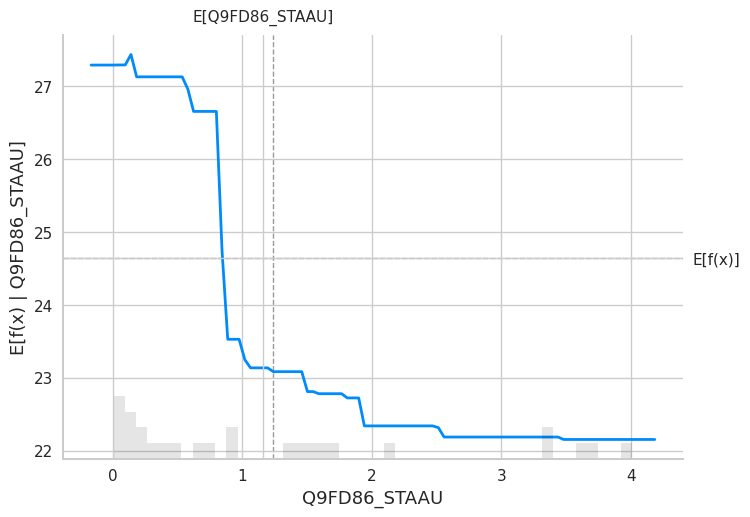

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

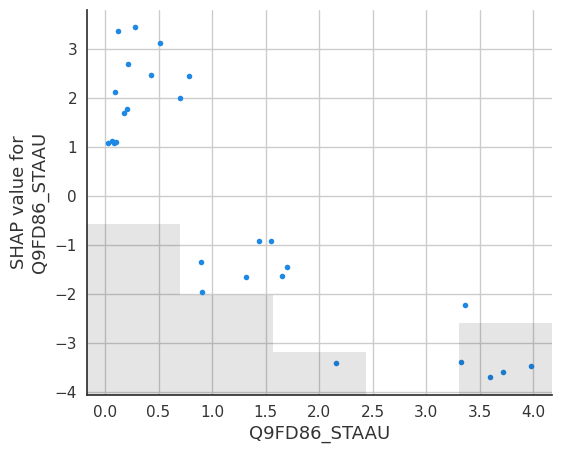

In [8]:
dl.pdplot("Q9FD86_STAAU")
dl.shap_scatter("Q9FD86_STAAU")

## Sampling

In [22]:
from scipy.stats import qmc

# Rearrange bounds to match input variables
# dl.bounds['Q40322_MENSP'].loc['min'] = 14
# dl.bounds['Q9FD86_STAAU'].loc['max'] = 0.3
# dl.bounds['ERG8_YEAST'].loc['max'] = 0.5

sampler = qmc.LatinHypercube(d=dl.X.shape[1])
sample = sampler.random(100)
LB = dl.bounds.T['min'].values.tolist()
UB = dl.bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=dl.X.columns)
sample_df["pred"] = dl.model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(3)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
23,0.062992,0.867678,1.937984,0.754763,2.671182,12.661210,2.267688,0.736252,3.360284,66.286415
40,0.115191,1.234163,2.232179,1.291670,2.829774,11.404274,1.598272,0.880028,2.682791,61.000568
31,0.293289,1.076666,2.298293,0.937192,3.511618,13.898034,1.184981,2.812479,3.230843,56.194672


In [49]:
from nbsynthetic.data_preparation import SmartBrain
from nbsynthetic.vgan import GAN
from nbsynthetic.synthetic import synthetic_data

best_df = dl.df[dl.df["cluster"] == top_cluster]
best_df.drop(['Limonene', 'cluster', 'pred'], axis=1, inplace=True)

SB = SmartBrain()
df = SB.nbEncode(best_df)

samples = 1000
new_df = synthetic_data(GAN, df, samples=samples)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


Epoch (1/10) | D. loss: 0.72 | G. loss: 0.69 |: 100%|##########| 1/1 [00:02<00:00,  2.46s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch (2/10) | D. loss: 0.69 | G. loss: 0.69 |: 100%|##########| 1/1 [00:00<00:00, 10.65it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch (3/10) | D. loss: 0.69 | G. loss: 0.67 |: 100%|##########| 1/1 [00:00<00:00, 10.33it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch (4/10) | D. loss: 0.71 | G. loss: 0.68 |: 100%|##########| 1/1 [00:00<00:00, 10.68it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch (5/10) | D. loss: 0.67 | G. loss: 0.67 |: 100%|##########| 1/1 [00:00<00:00,  8.74it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch (6/10) | D. loss: 0.67 | G. loss: 0.67 |: 100%|##########| 1/1 [00:00<00:00, 10.33it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch (7/10) | D. loss: 0.69 | G. loss: 0.67 |: 100%|##########| 1/1 [00:00<00:00, 10.05it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch (8/10) | D. loss: 0.69 | G. loss: 0.68 |: 100%|##########| 1/1 [00:00<00:00, 10.07it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch (9/10) | D. loss: 0.69 | G. loss: 0.68 |: 100%|##########| 1/1 [00:00<00:00,  9.25it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch (10/10) | D. loss: 0.69 | G. loss: 0.68 |: 100%|##########| 1/1 [00:00<00:00,  9.70it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


In [50]:
new_df['Limonene'] = dl.model.predict(new_df)
new_df.sort_values('Limonene', ascending=False, inplace=True)
new_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
300,0.174261,0.536757,2.809611,0.304921,1.424660,9.864558,0.759794,0.602481,0.568413,70.599678
482,0.179864,0.636272,2.707700,0.338025,1.465669,9.853407,0.782096,0.552426,0.473201,70.546196
689,0.178129,0.631712,3.115641,0.339420,1.613437,9.677793,0.808075,0.561969,0.505099,70.546196
840,0.176557,0.685742,3.058393,0.380020,1.695416,10.065562,0.791222,0.480264,0.510883,70.546196
461,0.178142,0.664289,3.181300,0.368131,1.598952,10.335581,0.860594,0.569529,0.530853,70.546196
...,...,...,...,...,...,...,...,...,...,...
574,0.208586,0.631792,1.945950,0.286805,1.666456,5.273469,0.253130,0.458132,0.460735,50.271297
575,0.193456,0.598973,2.059451,0.292707,1.747837,5.453616,0.254515,0.368364,0.517810,50.271297
67,0.221749,0.632714,1.942096,0.296437,1.544787,5.040125,0.256262,0.399475,0.460186,50.271297
313,0.224230,0.696017,1.852700,0.292249,1.797673,4.703397,0.224500,0.373883,0.415873,50.271297


In [44]:
# Keep only indexes in DBTL_B
original_df = pd.read_csv(PATH, index_col=0)
# Reorder columns to mach new_df 
original_df = original_df[INPUT_VARS + RESPONSE_VARS]
original_df[original_df.index.isin(DBTL_B)]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL.Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


In [26]:
from nbsynthetic.statistics import mmd_rbf, Wilcoxon, Student_t, Kolmogorov_Smirnov

mmd_rbf(df, new_df, gamma=None)
# Wilcoxon(df, new_df)
# Student_t(df, new_df)
# Kolmogorov_Smirnov(df, new_df)

Maximum Mean Discrepance = 0.31357


In [27]:
from nbsynthetic.statistics import plot_histograms

plot_histograms(df, new_df)